# **Homework 6**
# **Fairness**
# MIMUW XAI WINTER 2022/2023

#  Task 1


Demographic parity:

$\frac{P( \hat{Y} | A = B) }{P( \hat{Y}| A = R)} = 
\frac{0.65}{0.5} = 1.3$ 

Equal opportunity:

$\frac{P( \hat{Y} | A = B, Y = 1) }{P( \hat{Y} | A = R, Y = 1)} = 
\frac{0.75}{0.5} = 1.5$ 

Predictive rate parity:

$\frac{P( Y | A = B, \hat{Y}= 1) }{P( Y | A = R, \hat{Y} = 1)} = 
\frac{\frac{60}{65}}{0.5} = \frac{120}{65} \approx 1.85$ 



# Task 2

In this homework we used adult income https://www.kaggle.com/datasets/wenruliu/adult-income-dataset dataset from kaggle.

## Ad. 1
I prepared the data (onehot encoding) and
trained RandomForestClassifier model.The model achieved 86% accuracy. 



## Ad. 2 
I selected gender as protected attribute and calculated fairness. Resulst are shown below:


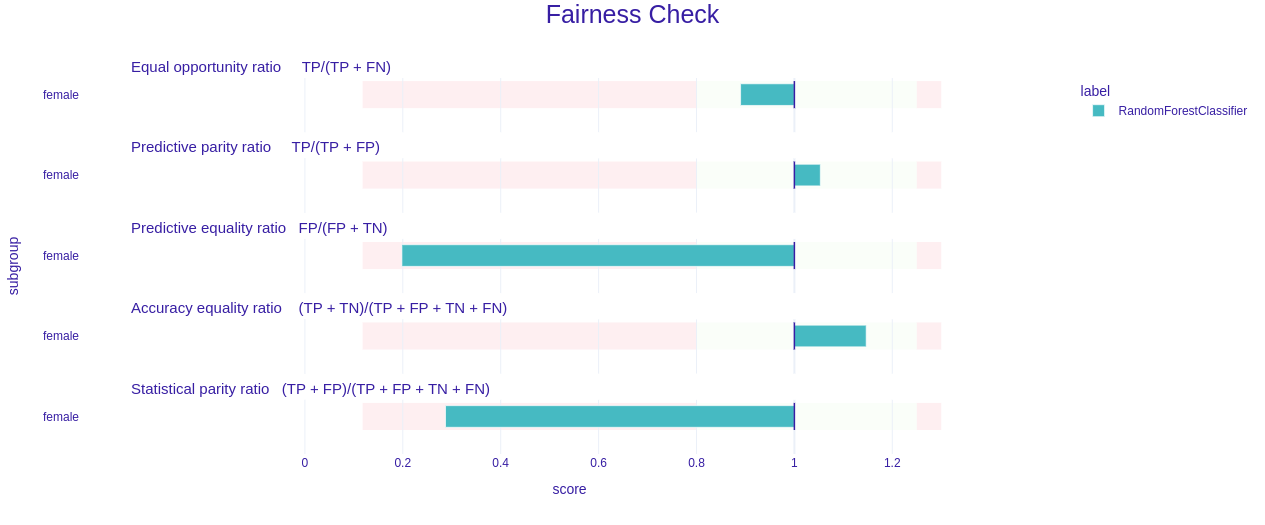

We observe that model is based against females. Fairness is not satisfied in "Predictive equality ratio" and "Statistical parity ratio".

## Ad. 3

I trained RandomForestClassifier model with parameter max_depth=3 and run fairness check. Results are shown below:

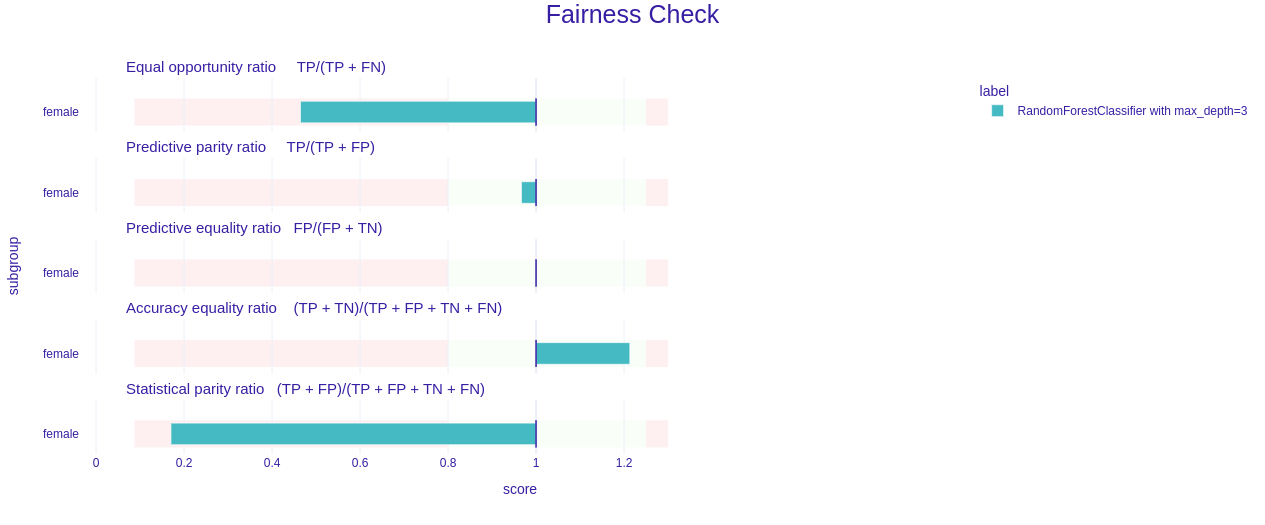

As with simple model, we observe that model is based against females. This time fairness is not satisfied in "Equal opportunity ratio" and "Statistical parity ratio".

## Ad.4  

I trained RandomForestClassifier model on data without protected attribute. Fairness check results are below:

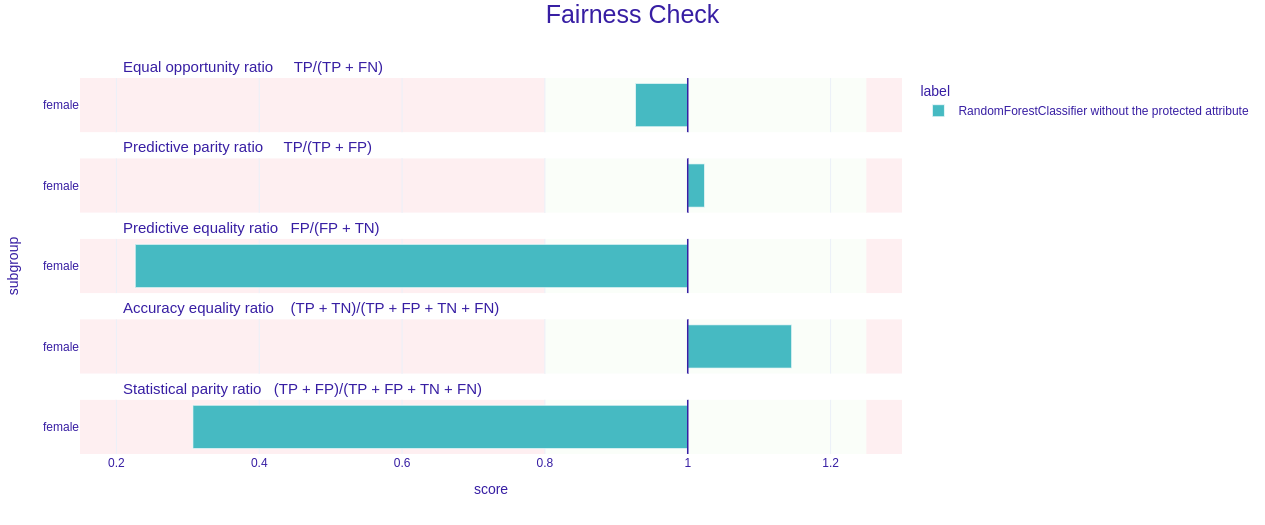

These results are very similar to fairness check of the first model.

# Ad. 5

---

|recall	|precision|	f1	|accuracy	|auc|
|---|---|---|---|---|
| RandomForestClassifier |	0.644541 |	0.721408|	0.680812|	0.858327|	0.906362|
| RandomForestClassifier max_dept=3 |	0.142795|	0.990909|	0.249618|	0.798751|	0.900373|
|RandomForestClassifier without prot|	0.634934|	0.724104|	0.676594|	0.857713|	0.906273|

Unsurprisingly RandomForestClassifier with max_dept=3 has much worse metrics. RandomForestClassifier with and without protected attribute have similar metrics ( as well as their fairness checks). Unfortunately we did not get fair model.

# Appendix

## 0. Setup

In [1]:
!pip install dalex shap catboost lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.9 MB/s 
     |████████████████████████████████| 575 kB 45.9 MB/s 
     |████████████████████████████████| 76.6 MB 24 kB/s 
     |████████████████████████████████| 275 kB 48.3 MB/s 
  Created wheel for dalex: filename=dalex-1.5.0-py3-none-any.whl size=1043321 sha256=4d139c20291beb3fdb443676038c165bebdd61b7ba341bb1c3591043bc555c6e
  Stored in directory: /root/.cache/pip/wheels/b1/02/58/77ac4cb307fec9f3324c6aa4f9f23a7b0e886e313ebc280257
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=83eace1b2287f2f21233da422eb724878f2467d0af820941985cea6084c5dffc
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built dalex lime


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd
import lime

import dalex as dx
import shap

In [57]:
!unzip adult.zip

Archive:  adult.zip
replace adult.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [58]:
df = pd.read_csv("adult.csv")
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Dataset consists of features that are nonnumerical. Let's  hot encode them first.

In [59]:
X = df.drop(columns=['income'])
X = pd.get_dummies(X, drop_first=True)
y = df['income'] == ">50K"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
     

Preparing train and test samples.

In [60]:
X_train

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
37193,42,145175,10,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
31093,52,175029,6,0,0,35,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
33814,34,172664,9,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
14500,28,125791,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
23399,46,28419,11,0,0,50,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,36,635913,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
44732,34,107624,10,0,0,50,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
38158,28,250135,10,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
860,46,96652,11,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## 1. Simple model

In [61]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
predictions_random_forest = random_forest.predict(X_test)
random_forest_acc = accuracy_score(predictions_random_forest,y_test)
model = random_forest
random_forest_acc

0.8581226328180981

The model achieved 86% accuracy.

In [62]:
explainer = dx.Explainer(model, X_test, y_test)

Preparation of a new explainer is initiated

  -> data              : 9769 rows 100 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 9769 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7f7ecc8fd940> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



  -> predicted values  : min = 0.0, mean = 0.242, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.00776, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


In [63]:
explainer.model_performance(cutoff=y_train.mean())

,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.836245,0.566903,0.675723,0.811854,0.906362


# 2. Check fairness for gender

In [81]:
protected_variable = X_test.gender_Male.apply(lambda x: "male" if x else "female")

privileged_group = "male"

fobject = explainer.model_fairness(
    protected=protected_variable,
    privileged=privileged_group
)

In [82]:
fobject.fairness_check()

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'male'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
             TPR       ACC       PPV       FPR       STP
female  0.890076  1.146699  1.052999  0.198198  0.287273


In [83]:
fobject.plot()

## 3. Different param


In [90]:
random_forest_diff_param = RandomForestClassifier(max_depth=3)
random_forest_diff_param.fit(X_train, y_train)
predictions_random_forest_diff_param = random_forest_diff_param.predict(X_test)
random_forest_acc_diff_param = accuracy_score(predictions_random_forest_diff_param,y_test)
model_diff_param = random_forest_diff_param
print( random_forest_acc_diff_param )

explainer_diff_param = dx.Explainer(model_diff_param, X_test, y_test)

fobject_diff_param = explainer_diff_param.model_fairness(
    protected=protected_variable,
    privileged=privileged_group,
    label="RandomForestClassifier with max_depth=3",
)

0.7987511516020064
Preparation of a new explainer is initiated

  -> data              : 9769 rows 100 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 9769 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7f7ecc8fd940> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



  -> predicted values  : min = 0.0569, mean = 0.24, max = 0.643
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.625, mean = -0.0054, max = 0.91
  -> model_info        : package sklearn

A new explainer has been created!


In [91]:
fobject_diff_param.fairness_check()

Bias detected in 2 metrics: TPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'male'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
             TPR       ACC       PPV  FPR       STP
female  0.464516  1.213137  0.966767  NaN  0.170213

Warning!
Take into consideration that NaN's are present, consider checking 'metric_scores' plot to see the difference


In [92]:
fobject_diff_param.plot()

# 4.Without protected

In [93]:
X_train_without_prot, X_test_without_prot = X_train.drop("gender_Male", axis=1), X_test.drop("gender_Male", axis=1)


random_forest_wo_prot = RandomForestClassifier()
random_forest_wo_prot.fit(X_train_without_prot, y_train)
predictions_random_forest_wo_prot = random_forest_wo_prot.predict(X_test_without_prot)
random_forest_acc_wo_prot = accuracy_score(predictions_random_forest_wo_prot,y_test)
model_wo_prot = random_forest_wo_prot
print( random_forest_acc_wo_prot )

explainer_wo_prot = dx.Explainer(model_wo_prot, X_test_without_prot, y_test)

fobject_wo_prot = explainer_wo_prot.model_fairness(
    protected=protected_variable,
    privileged=privileged_group,
    label="RandomForestClassifier without the protected attribute",
)

0.8584297266864571
Preparation of a new explainer is initiated

  -> data              : 9769 rows 99 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 9769 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7f7ecc8fd940> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



  -> predicted values  : min = 0.0, mean = 0.241, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.00673, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


In [94]:
fobject_wo_prot.fairness_check()

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'male'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
             TPR       ACC       PPV       FPR       STP
female  0.926791  1.145477  1.023546  0.226415  0.307116


In [95]:
fobject_wo_prot.plot()

## 5. Comparison

In [98]:
fobject.plot([fobject_diff_param,fobject_wo_prot], show=False)

In [99]:
pd.concat([
    explainer.model_performance().result, 
    explainer_diff_param.model_performance().result,
    explainer_wo_prot.model_performance().result,
], axis=0)

,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.644541,0.721408,0.680812,0.858327,0.906362
RandomForestClassifier,0.142795,0.990909,0.249618,0.798751,0.900373
RandomForestClassifier,0.634934,0.724104,0.676594,0.857713,0.906273
